Borrowed Heavily from https://www.kaggle.com/nitin194/twitter-sentiment-analysis-word2vec-doc2vec

In [2]:
import re
import nltk
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from nltk.stem.porter import *


%matplotlib inline

First off let's access some of the data files for this task

In [3]:
names = ['TweetID', 'Sentiment', 'Tweet']

train = pd.read_csv('../Datasets/dataset/train/twitter-2016train-A.txt', delimiter='\t', names=names)
test = pd.read_csv('../Datasets/dataset/train/twitter-2016test-A.txt', delimiter='\t', names=['TweetID', 'Sentiment', 'Tweet', 'tidy_tweet'])

Now let's examine what the content looks like for positive, negative, and neutral tweets

In [4]:
train[train['Sentiment']=='positive'].head()

,TweetID,Sentiment,Tweet
5,629226490152914944,positive,"Microsoft, I may not prefer your gaming branch..."
8,629650766580609026,positive,Just ordered my 1st ever tablet; @Microsoft Su...
10,630159517058142208,positive,"Sunday morning, quiet day so time to welcome i..."
14,630818265799921664,positive,Innovation for jobs is just around the corner ...
19,631368262979297281,positive,#Vote for @AIESEC to become the 10th Global no...


In [5]:
train[train['Sentiment']=='negative'].head()

,TweetID,Sentiment,Tweet
0,628949369883000832,negative,dear @Microsoft the newOoffice for Mac is grea...
1,628976607420645377,negative,@Microsoft how about you make a system that do...
2,629023169169518592,negative,I may be ignorant on this issue but... should ...
3,629179223232479232,negative,"Thanks to @microsoft, I just may be switching ..."
6,629345637155360768,negative,@MikeWolf1980 @Microsoft I will be downgrading...


In [6]:
train[train['Sentiment']=='neutral'].head()

,TweetID,Sentiment,Tweet
4,629186282179153920,neutral,If I make a game as a #windows10 Universal App...
13,630807124872970240,neutral,@spyderharrison @Microsoft the reason I ask is...
15,630909171437801472,neutral,OK this is my pure speculation. @Microsoft ow...
16,630982270409572352,neutral,We are still taking registrations for our Educ...
26,631936716522278912,neutral,@kenttaylor333 @YourAnonNews @Microsoft the op...


Basic statistics on data

In [7]:
train['Sentiment'].value_counts()

positive    3017
neutral     2001
negative     850
Name: Sentiment, dtype: int64

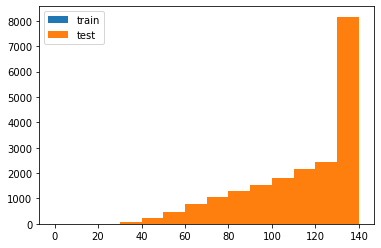

In [8]:
plt.hist(train.Tweet.str.len(), label='train', bins=14, range=[0,140])
plt.hist(test.Tweet.str.len(), label='test', bins=14, range=[0,140])
plt.legend()
plt.show()

So now we want to do some data cleaning to get rid of unwanted stuff not relevant to sentiment classification

In [9]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

We want to remove several things out of raw tweets
1. Twitter handles due to privacy concerns
2. Punctuation, numbers, and special characters
3. Small words
4. Normalize textual data so we don't have different bases

1. Removing Twitter Handles

In [10]:
train['tidy_tweet'] = np.vectorize(remove_pattern)(train['Tweet'], "@[\w]*")
train.head()

,TweetID,Sentiment,Tweet,tidy_tweet
0,628949369883000832,negative,dear @Microsoft the newOoffice for Mac is grea...,"dear the newOoffice for Mac is great and all,..."
1,628976607420645377,negative,@Microsoft how about you make a system that do...,how about you make a system that doesn't eat ...
2,629023169169518592,negative,I may be ignorant on this issue but... should ...,I may be ignorant on this issue but... should ...
3,629179223232479232,negative,"Thanks to @microsoft, I just may be switching ...","Thanks to , I just may be switching over to ."
4,629186282179153920,neutral,If I make a game as a #windows10 Universal App...,If I make a game as a #windows10 Universal App...


2. Removing Punctuations, Numbers, and Special Characters

In [11]:
train.tidy_tweet = train.tidy_tweet.str.replace("[^a-zA-Z#]", " ")
train.head()

,TweetID,Sentiment,Tweet,tidy_tweet
0,628949369883000832,negative,dear @Microsoft the newOoffice for Mac is grea...,dear the newOoffice for Mac is great and all ...
1,628976607420645377,negative,@Microsoft how about you make a system that do...,how about you make a system that doesn t eat ...
2,629023169169518592,negative,I may be ignorant on this issue but... should ...,I may be ignorant on this issue but should ...
3,629179223232479232,negative,"Thanks to @microsoft, I just may be switching ...",Thanks to I just may be switching over to
4,629186282179153920,neutral,If I make a game as a #windows10 Universal App...,If I make a game as a #windows Universal App...


3. Removing Short Words

In [12]:
train.tidy_tweet = train.tidy_tweet.apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
train.head()

,TweetID,Sentiment,Tweet,tidy_tweet
0,628949369883000832,negative,dear @Microsoft the newOoffice for Mac is grea...,dear newOoffice great Lync update
1,628976607420645377,negative,@Microsoft how about you make a system that do...,about make system that doesn friggin discs Thi...
2,629023169169518592,negative,I may be ignorant on this issue but... should ...,ignorant this issue should celebrate parental ...
3,629179223232479232,negative,"Thanks to @microsoft, I just may be switching ...",Thanks just switching over
4,629186282179153920,neutral,If I make a game as a #windows10 Universal App...,make game #windows Universal Will #xboxone own...


4. Text Normalization

In [13]:
tokenized_tweet = train.tidy_tweet.apply(lambda x: x.split())
tokenized_tweet.head()

0              [dear, newOoffice, great, Lync, update]
1    [about, make, system, that, doesn, friggin, di...
2    [ignorant, this, issue, should, celebrate, par...
3                      [Thanks, just, switching, over]
4    [make, game, #windows, Universal, Will, #xboxo...
Name: tidy_tweet, dtype: object

In [14]:
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0                [dear, newooffic, great, lync, updat]
1    [about, make, system, that, doesn, friggin, di...
2    [ignor, thi, issu, should, celebr, parent, lea...
3                          [thank, just, switch, over]
4    [make, game, #window, univers, will, #xboxon, ...
Name: tidy_tweet, dtype: object

In [15]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
train['tidy_tweet'] = tokenized_tweet
train.head()

,TweetID,Sentiment,Tweet,tidy_tweet
0,628949369883000832,negative,dear @Microsoft the newOoffice for Mac is grea...,dear newooffic great lync updat
1,628976607420645377,negative,@Microsoft how about you make a system that do...,about make system that doesn friggin disc thi ...
2,629023169169518592,negative,I may be ignorant on this issue but... should ...,ignor thi issu should celebr parent leav chang...
3,629179223232479232,negative,"Thanks to @microsoft, I just may be switching ...",thank just switch over
4,629186282179153920,neutral,If I make a game as a #windows10 Universal App...,make game #window univers will #xboxon owner a...


Just for convenience sake I'll make a single function that does all that for you

In [16]:
test.head()

,TweetID,Sentiment,Tweet,tidy_tweet
0,619950566786113536,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T...",NaN
1,619969366986235905,neutral,Order Go Set a Watchman in store or through ou...,NaN
2,619971047195045888,negative,If these runway renovations at the airport pre...,NaN
3,619974445185302528,neutral,If you could ask an onstage interview question...,NaN
4,619987808317407232,positive,A portion of book sales from our Harper Lee/Go...,NaN


In [17]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

def tidy_tweet(dataset, min_len=3):
    dataset['tidy_tweet'] = np.vectorize(remove_pattern)(dataset['Tweet'], "@[\w]*")
    dataset.tidy_tweet = dataset.tidy_tweet.str.replace("[^a-zA-Z#]", " ")
    dataset.tidy_tweet = dataset.tidy_tweet.apply(lambda x: ' '.join([w for w in x.split() if len(w) > min_len]))
    tokenized_tweet = dataset.tidy_tweet.apply(lambda x: x.split())

    stemmer = PorterStemmer()
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
    tokenized_tweet.head()
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    dataset['tidy_tweet'] = tokenized_tweet
    return dataset

test = tidy_tweet(test)
test.head()

,TweetID,Sentiment,Tweet,tidy_tweet
0,619950566786113536,neutral,"Picturehouse's, Pink Floyd's, 'Roger Waters: T...",picturehous pink floyd roger water walll open ...
1,619969366986235905,neutral,Order Go Set a Watchman in store or through ou...,order watchman store through websit befor tues...
2,619971047195045888,negative,If these runway renovations at the airport pre...,these runway renov airport prevent from see ta...
3,619974445185302528,neutral,If you could ask an onstage interview question...,could onstag interview question miss tomorrow ...
4,619987808317407232,positive,A portion of book sales from our Harper Lee/Go...,portion book sale from harper watchman releas ...


Next Step Is We Need to Train Word2Vec on our Corpus

In [18]:
%%time

tokenized_tweet = train['tidy_tweet'].apply(lambda x: x.split())

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size = 200, #desired number of features, 200 seems to be a common width, no idea why
            window = 5, #context window size
            min_count =2, #ignores all words with total freq lower than 2
            sg = 1, #encoding for skip-gram model
            hs = 0,
            negative = 10, #for negative sampling
            workers = 2, #no. of cores
            seed = 34
)

model_w2v.train(tokenized_tweet, total_examples = len(train['tidy_tweet']), epochs=20)

Wall time: 25.5 s


(1046178, 1331040)

In [19]:
model_w2v.wv.most_similar(positive="trump")

[('donald', 0.8051669001579285),
 ('protest', 0.7070713043212891),
 ('cruz', 0.6580299139022827),
 ('loyalti', 0.6494956016540527),
 ('#makeamericagreatagain', 0.6474908590316772),
 ('english', 0.6439023017883301),
 ('runner', 0.6393129825592041),
 ('bush', 0.6370007991790771),
 ('#trump', 0.6348357796669006),
 ('spanish', 0.6298032999038696)]

The dimensionality of our embedding space is 200, that means that each word is represented by a vector of 200 floating point numbers, isn't that convenient :).

But in order to make this dataset directly applicable to our neural networks we will need to produce a feature vector for all of the tweets.

Now since we are eliminating any words that are less than 3 chars in length, the max number of words we could have is 140/5, because each word has a space after it,  but we have to account for the fact that there will always be n-1 spaces so we'll add one and make the vector length 29.

In [20]:
model_w2v['trump']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 1.38560668e-01, -1.31284967e-01,  3.92329156e-01,  6.22116446e-01,
       -7.02205375e-02, -2.11930171e-01,  2.17334032e-01, -5.17392755e-01,
        2.52419859e-01, -2.24026501e-01,  8.80015433e-01, -3.46899033e-02,
       -4.27762151e-01,  5.89991689e-01, -1.83441937e-01, -1.00050569e+00,
        9.52548981e-02, -5.03819346e-01, -1.29338965e-01, -5.22997558e-01,
       -3.95571679e-01, -3.59569103e-01,  1.90603644e-01, -8.68877053e-01,
        3.42198253e-01, -2.77321905e-01, -1.08596962e-02,  3.59900028e-01,
       -2.19381735e-01,  3.16402137e-01, -4.52018946e-01,  2.30322286e-01,
       -6.65033832e-02, -2.38108337e-01,  2.14896962e-01,  3.53187621e-01,
        5.45436800e-01,  4.33614522e-01, -3.99256963e-03,  1.56217322e-01,
        3.97722572e-01,  1.21240042e-01, -2.58577943e-01,  9.22969759e-01,
       -2.06543859e-02,  5.10485709e-01,  1.33597925e-02,  5.97124875e-01,
       -1.11721065e-02,  3.01240683e-01,  5.38231075e-01,  1.63770854e-01,
       -1.47710443e-01,  

In [21]:
len(model_w2v['trump'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


200

Here we need to define a function that we can map onto our Tweets, the only reason being we'll get an error if the model can't find the word embedding. My solution to this is just to return a 0 vector if the word doesn't exist in our corpus.

In [22]:
def apply_model(model, token, dim=200):
    try:
        return model[token]
    except(KeyError):
        return np.zeros(dim)
    
apply_model(model_w2v, 'schmup') #Testing, yep, this word doesn't exist
        

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
inputs = []
for tweet_ind in range(len(tokenized_tweet)):
    feature_map = []
    for word in tokenized_tweet[tweet_ind]:
        feature_map.append(apply_model(model_w2v, word))
    for i in range(55 - len(feature_map)):
        feature_map.append(np.zeros(200))
    inputs.append(feature_map)
np.shape(inputs[5])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(55, 200)

In [24]:
print(tokenized_tweet[0])

['dear', 'newooffic', 'great', 'lync', 'updat']


In [25]:
print([i for i,v in enumerate(tokenized_tweet) if len(v) > 55])

[1064, 1878, 2134, 3336, 3692]


In [ ]:
tokenized_tweet[1878]